# Cycle-by-cycle analysis of waveform shape on REAL DATA

This tutorial will allow you to apply what you have learned about the motivation and algorithm employed by bycycle to analyze the waveform shape of visual cortical alpha oscillations in event-related, electrocorticography (ECoG) data.

## Preliminary necessities

### Library imports, magics, and settings

First, we need all the necessary machinery for our approach, but some rather unnecessary but pleasing aesthetics (i.e. plotting settings)

In [1]:
# Do magics
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

# Import necessary modules
from scipy import io
from scipy.stats import pearsonr

import numpy as np

import pandas as pd

from neurodsp import spectral
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series
from neurodsp.utils import create_times

from fooof import FOOOF
from fooof.analysis import get_band_peak_fm

from bycycle.features import compute_features
from bycycle.group import compute_features_2d
from bycycle.plts import plot_burst_detect_summary, plot_feature_categorical
from bycycle.utils import flatten_dfs

import matplotlib
import matplotlib.pyplot as plt

## Load and explore data

This data is from one ECoG channel in visual cortex during a go/no-go task. There are three event types in these data: non-target "standard" stimuli (sta), targets to which the subjects were to respond via manual button press (tar), and the times when they responded (resp).

We will focus on alpha oscillations, which have been shown to be functionally modulated in visual attention task. Here we will investigate whether there are differences in the waveform shape of these visual alpha oscillations between target (tar) and non-target (sta) stimuli. 

In [2]:
fs = 1000 # sampling rate of the data, in Hz

# load the visual cortical ECoG channel, and the event indices
data = io.loadmat('data/ecog_data.mat', squeeze_me=True)
sta = data['sta']
tar = data['tar']
resp = data['resp']
data = data['data']

Before investigating waveform shape, it is important to ensure that there are actually oscillations present in your data. This can be done by calculating and plotting the power spectrum for the data and checking if there is an oscillatory "bump" in the frequency band of interest. Since we are interested in alpha, we will check if there is an oscillatory "bump" between 7 and 13 Hz.

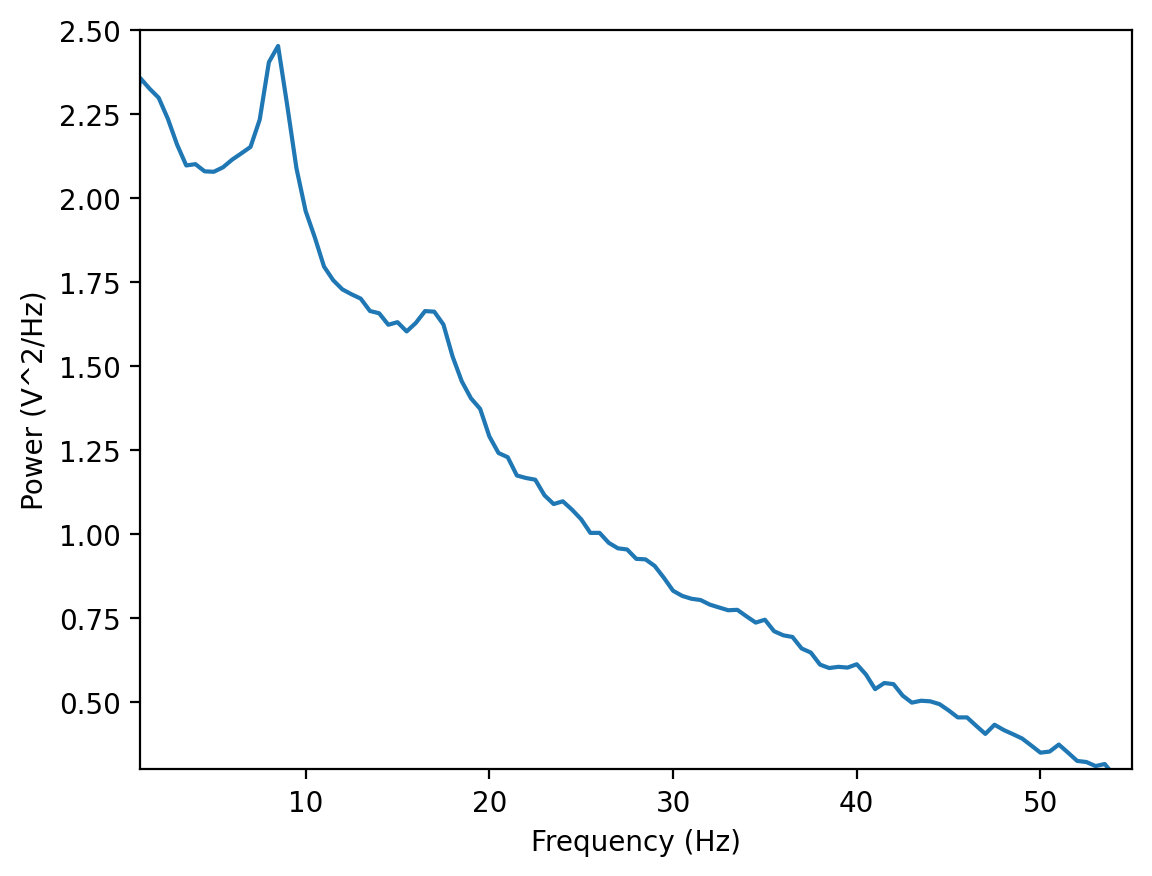

In [3]:
# Calculate power spectra
freq_mean, P_mean = spectral.compute_spectrum(data, fs, method='welch', window='hann', nperseg=fs*2) # mean of spectrogram (Welch)
# This breaks the data up into two-second windows (nperseg=fs*2)
# It then applies a hanning window to the time-series windows (window='hann')
# It then FFTs each hanning'd window, and then averages all those FFTs (method='welch')

# Plot PSD
plt.plot(freq_mean, np.log10(P_mean))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((1, 55))
plt.ylim((0.3, 2.5))
plt.show()

This power spectrum has a very prominent peak around 10 Hz and another lesser peak around 20 Hz that may be a harmonic (💡 **nonsinusoidal shape** 💡). 

We can verify if the second peak really is a harmonic by using spectral parameterization (i.e. FOOOF) to fit the peaks and check if the second peak's frequency is an integer multiple of the first's.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

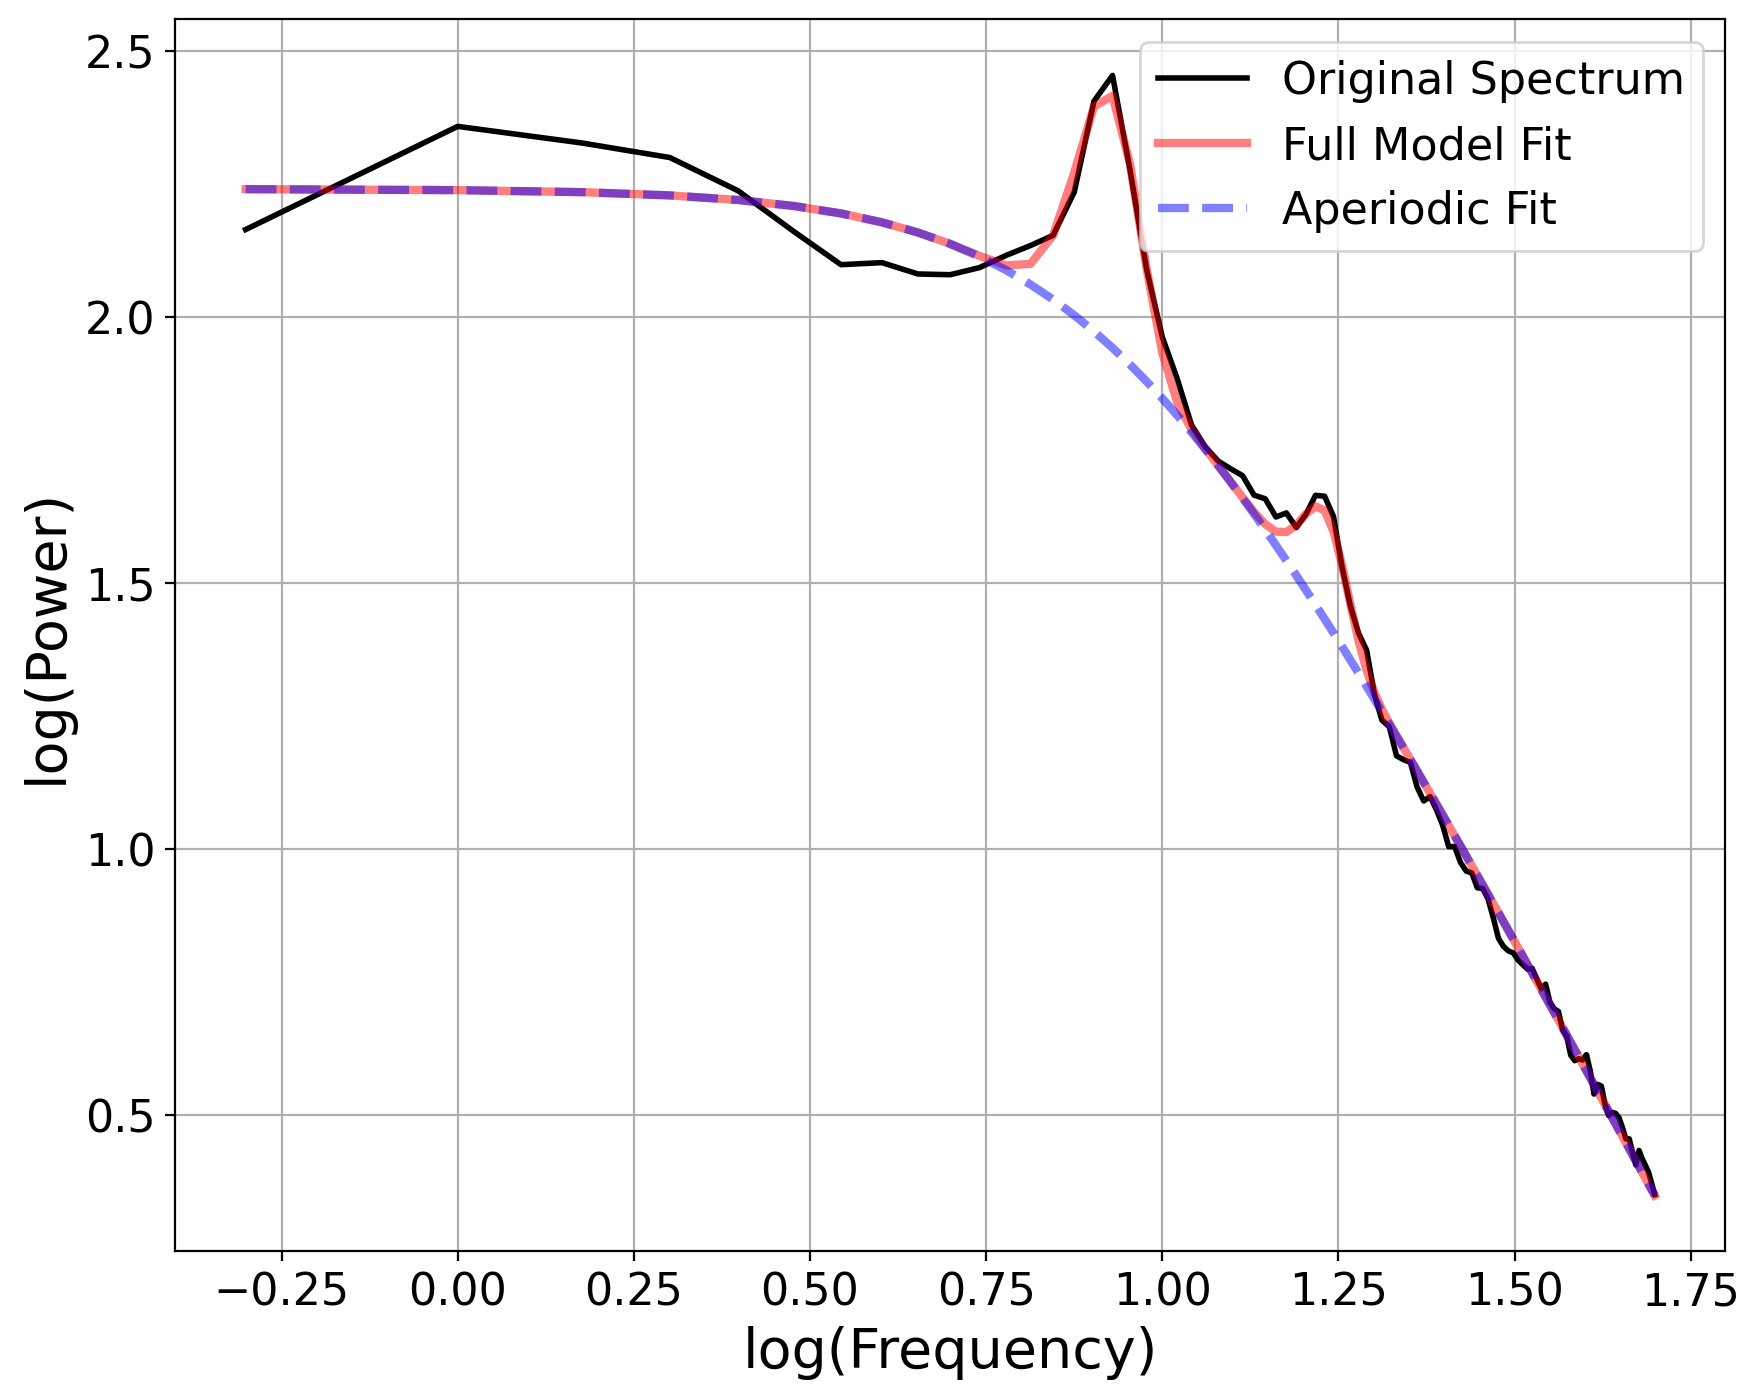

In [4]:
# Initialize a FOOOF object
fm = FOOOF(aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.5, 50]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freq_mean, P_mean, freq_range, plt_log=True)

In [5]:
# Check if CFs are integer multiples
center_freqs = fm.peak_params_[:, 0]
center_freqs / center_freqs[0]

array([1.       , 2.0259141])

The frequency of the second peak is very close to an integer multiple of that of the first peak, suggesting that it is a harmonic that may be caused by non-sinusoidal shape.

We can now use the specific alpha peak frequency for this channel and the seed for our bycycle algorithm. This should for better characterization of the waveform shape.

In [6]:
# Get personalized alpha band
f_alpha = (7, 13)  # band of interest
alpha_cf = get_band_peak_fm(fm, f_alpha)[0]
alpha_band = (alpha_cf - 2, alpha_cf + 2)

## Apply bycycle to extract waveform shape

### Preprocessing

Applying a lowpass filter aids localization of peaks and troughs of the oscillation, but it is important that the cutoff frequency is not so low that it deforms the shape of the oscillation of interest. Usually, around 3x the oscillatory frequency of interest works well at striking this balance.

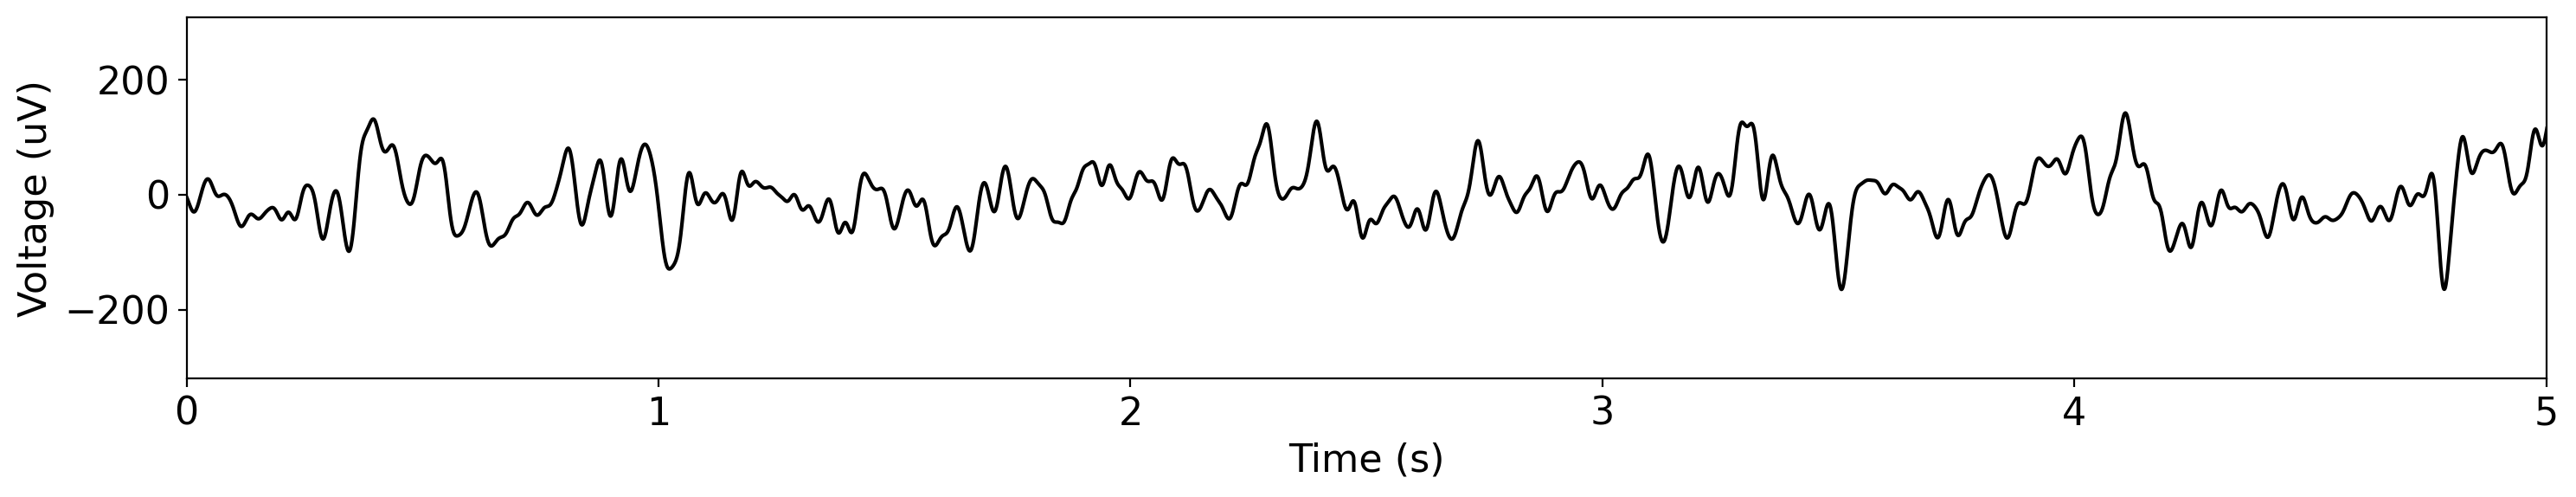

In [7]:
# Bandpass filter from 0.5 to 3x alpha band
filtered_sig = filter_signal(data, fs, 'lowpass', 3 * alpha_band[-1], remove_edges=False)

# Plot filtered signal
times = create_times(len(filtered_sig) / fs, fs)
plot_time_series(times, filtered_sig, xlim=(0, 5))

### Run bycycle on preprocessed data

Next, we can run bycycle on a short segment of the data just to see how well our parameter selection is working.

In [8]:
# Tuned burst detection parameters
threshold_kwargs = {'amp_fraction_threshold': .2,
                    'amp_consistency_threshold': .2,
                    'period_consistency_threshold': .5,
                    'monotonicity_threshold': .5,
                    'min_n_cycles': 3}

# Compute waveform shape features
df_bycycle = compute_features(filtered_sig[:5*fs], fs, alpha_band, threshold_kwargs=threshold_kwargs)

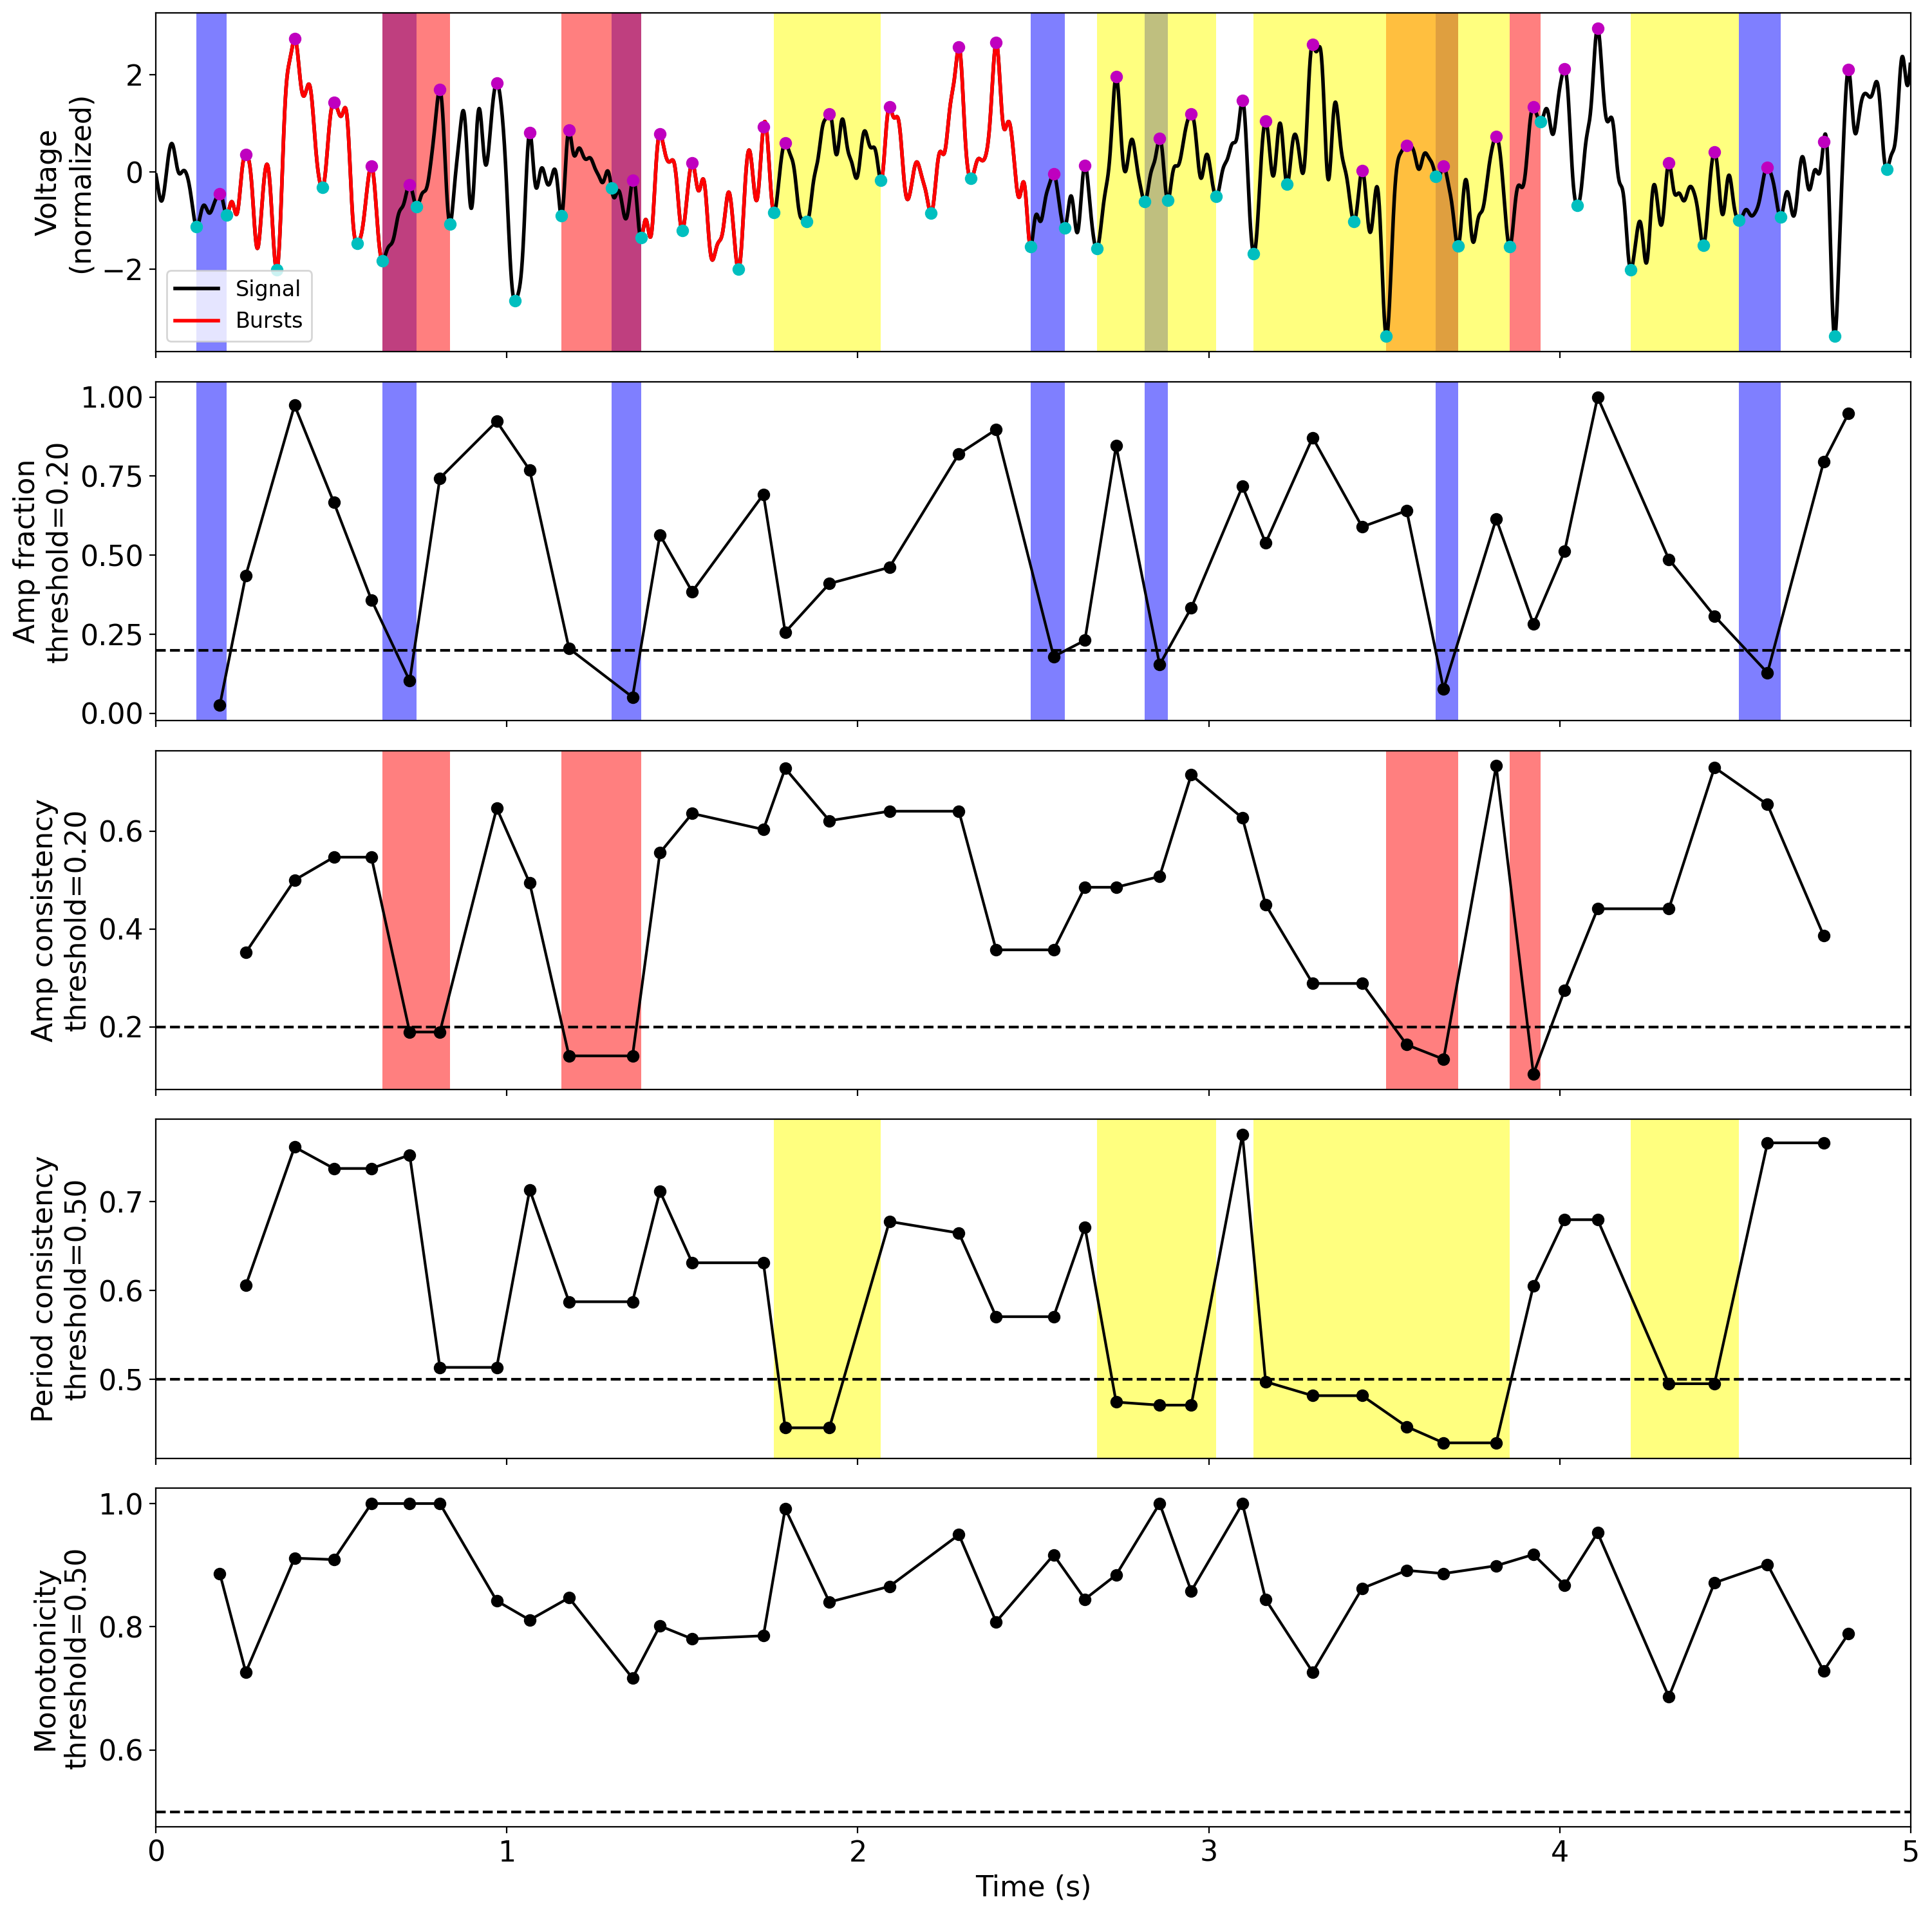

In [9]:
# Plot bursts
plot_burst_detect_summary(df_bycycle, filtered_sig[:5*fs], fs, threshold_kwargs, xlim=(0,5))

These parameters appear to be detect alpha bursts well, so we can continue and apply these parameters to extract waveform shape features in the whole dataset. 

## Event-related data

### Window data for each trial and plot ERPs

Next, we will investigate whether there are any event-related differences in the waveform shape of alpha bursts between presentation of non-target ("standard") and target stimuli. First, we need to slice up our raw time trace into events. Below is a function that takes the full time series and windows the trials as desired

In [10]:
def event_related(data, fs, indices, window, subtract_mean=None):
    """Take an input time series, vector of event indices, and window sizes,
    and return a 2d matrix of windowed trials around the event indices.
    
    Parameters
    ----------
    data : array-like 1d
        Voltage time series
    data : float
        Data sampling rate (Hz)
    indices : array-like 1d of integers
        Indices of event onset indices
    window : tuple (intengers)
        Window (in ms) around event onsets
    subtract_mean : tuple (intengers), optional
        if present, subtract the mean value in the subtract_mean window for each
        trial from that trial's time series (this is a trial-by-trial baseline)
    
    Returns
    -------
    event_related_matrix : array-like 2d
        Event-related times series around each index
        Each row is a separate event
    """
    
    # convert times (in ms) to indices of points along the array
    def windows_to_indices(fs, window_times):
        conversion_factor = (1/fs)*1000 # convert from time points to ms
        window_times = np.floor(np.asarray(window_times)/conversion_factor) # coonvert
        window_times = window_times.astype(int) # turn to ints
        
        return window_times
    
    window_idx = windows_to_indices(fs, window) # convert times (in ms) to indices
    inds = indices + np.arange(window_idx[0],window_idx[1])[:,None] # build matrix of indices
    event_times = np.arange(window[0], window[1], fs/1000)
    
    event_related_matrix = data[inds] # grab the data
    event_related_matrix = np.squeeze(event_related_matrix).T # make sure it's in the right format
    
    # baseline, if requested
    if subtract_mean is not None:
        basewin = [0,0]
        basewin[0] = np.argmin(np.abs(event_times-subtract_mean[0]))
        basewin[1] = np.argmin(np.abs(event_times-subtract_mean[1]))
        event_related_matrix = event_related_matrix - event_related_matrix[:, basewin[0]:basewin[1]].mean(axis=1, keepdims=True)
    
    return event_times, event_related_matrix

We can then use this function to window our data and plot ERPs for the two types of stimuli.

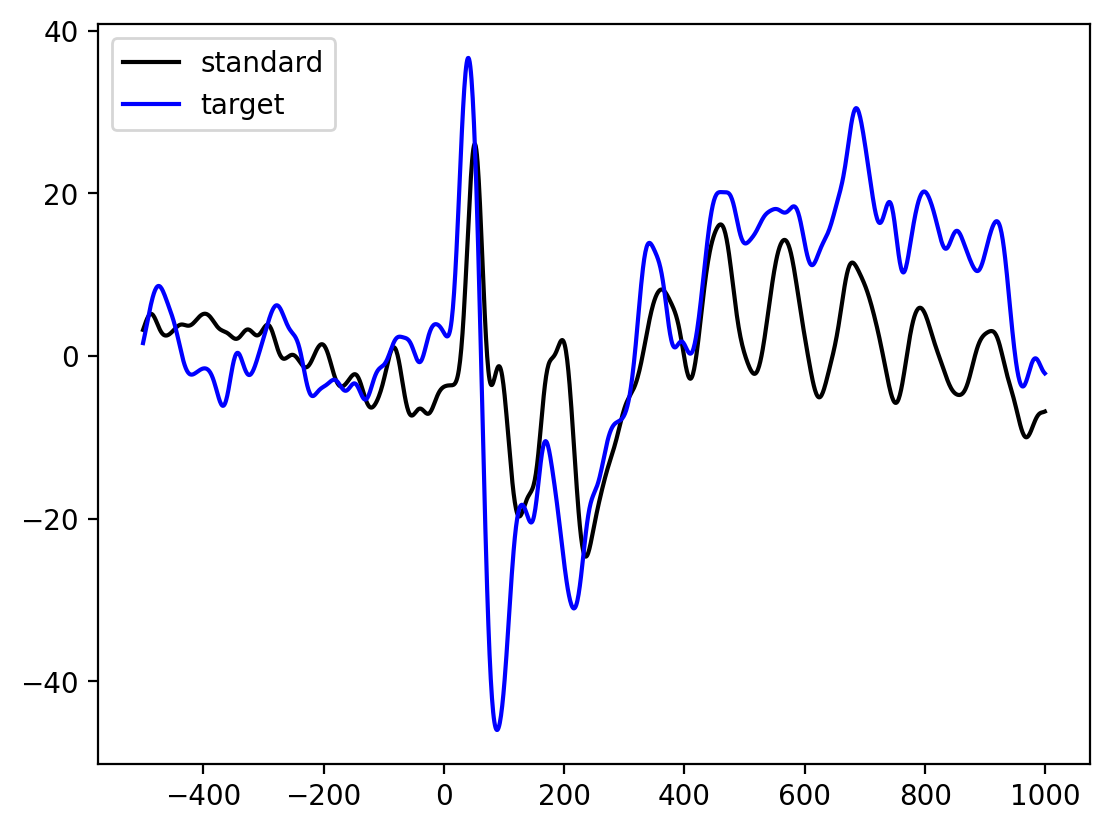

In [11]:
event_times, sta_erp = event_related(filtered_sig, fs, sta, (-500,1000), (-500,0))
_, tar_erp = event_related(filtered_sig, fs, tar, (-500,1000), (-500,0))

plt.plot(event_times, np.mean(sta_erp, 0), 'k', label='standard')
plt.plot(event_times, np.mean(tar_erp, 0), 'b', label='target')
plt.legend()
plt.show()

### Analyze waveform shape of alpha bursts

Now with our event-related data isolated, we will compute the waveform shape features using the bycycle package. We are only interested in the actual bursts, so we can discard any cycles which are not considered bursts. We also can compute measures of asymmetry and frequency from the bycycle output. Finally, we average across the cycles of bursts from each trial, so that we can make comparisons across trials of differing types (i.e. tar and sta trials).

In [12]:
def compute_features_each_trial(erp, fs, band, threshold_kwargs):
    """Compute waveform shape features for each trial, averaging across cycles within one trial. 
    
    Parameters
    ----------
    erp : array-like 2d
        Windowed trial data of shape (num_trials, num_timepts). 
    fs : float
        Data sampling rate (Hz).
    band : tuple
        Band of interest, defined by (f_min, f_max).
    threshold_kwargs : tuple of float/int
        Keyword arguments to be passed to bycycle.
    trial_mean : bool, optional (default: True)
        if True, compute the mean features for cycles within the same trial.
    
    Returns
    -------
    df_bursts : pd.DataFrame
        DataFrame with shape (n_trials, n_features). Each row contains the computed features 
        for one trial.
    """
    # Compute features
    df_bycycle = flatten_dfs(compute_features_2d(erp, fs, alpha_band, compute_features_kwargs={
        'threshold_kwargs': threshold_kwargs}), np.arange(erp.shape[0]))
    
    # Calculate asymmetry
    sym_feats = [feat for feat in df_bycycle.columns if 'sym' in feat]
    for feat in sym_feats:
        df_bycycle[feat.replace('sym', 'asym')] = np.abs(df_bycycle[feat] - 0.5) 
    
    # Calculate frequency
    df_bycycle['freq'] = fs / df_bycycle['period'] 
    
    # Just get bursts
    df_bursts = df_bycycle.query('is_burst')
    
    # Take average for each trial
    df_bursts = df_bursts.groupby('Label').mean()
    return df_bursts

We can then use this function to calculate the waveform shape features for target and non-target trials, then combine these two output DataFrames using Pandas.

In [13]:
# Compute features for each trial
df_bursts_sta = compute_features_each_trial(sta_erp, fs, alpha_band, threshold_kwargs)
df_bursts_tar = compute_features_each_trial(tar_erp, fs, alpha_band, threshold_kwargs)

# Combine DataFrames for target and non-target ("standard")
df_bursts_sta['stim'] = 'non-target'
df_bursts_tar['stim'] = 'target'
df_bursts = pd.concat([df_bursts_sta, df_bursts_tar])

Finally, we can make a function to plot the waveform shape features we are interested in between trial types.

In [14]:
def plot_waveform_features(df_bursts, feats_to_plot, x):
    """Plot waveform shape features of interest, contrasting by one feature of interest (x).
    
     Parameters
    ----------
    df_bursts : pd.DataFrame
        DataFrame with shape (n_trials, n_features). Each row contains the computed features 
        for one trial.
    feats_to_plot : dict
        The features to plot, with keys being the name of the feature within df_bursts and the
        values being how the feature should be labeled on the y-axis of its corresponding 
        subplot.
    x : str
        The name of the contrast feature.
    """
    # Create subplots, one for each feature to plot
    fig, axes = plt.subplots(2, len(feats_to_plot)//2)
    
    for ax, (feat, title) in zip(axes.flatten(), feats_to_plot.items()):
        data = [df_bursts.query("stim == 'target'")[feat],
                df_bursts.query("stim == 'non-target'")[feat]]
        ax.violinplot(data, showmeans=True)
        ax.set_xticks(np.arange(1, 3), labels=['Target', 'Non-Target'])
        ax.set_ylabel(title)
    plt.tight_layout()
    return

We will focus on the frequency, amplitude, and asymmetry measures. 

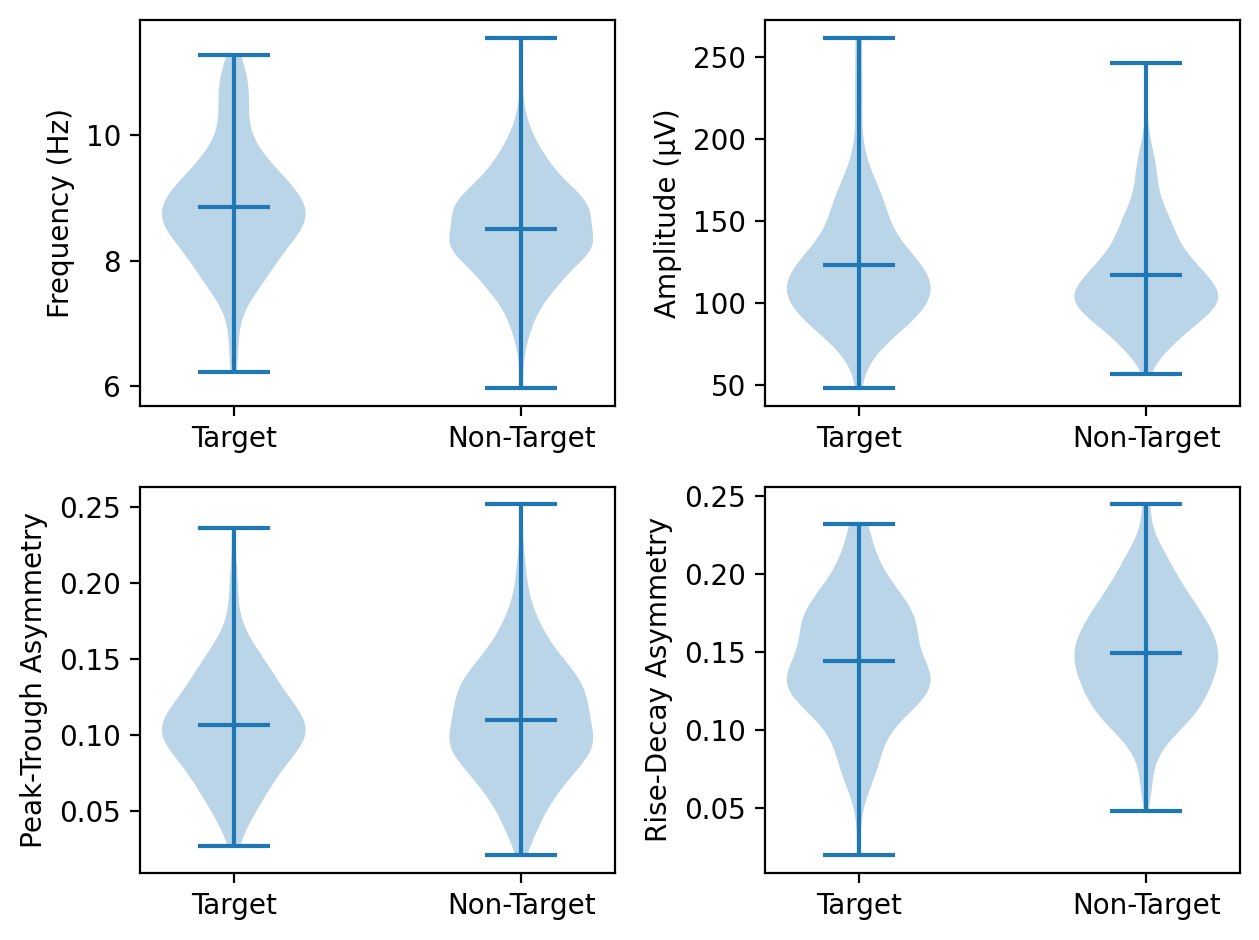

In [15]:
# Specify features to plot
feats_to_plot = {'freq': 'Frequency (Hz)', 
                 'volt_amp': 'Amplitude (μV)', 
                 'time_ptasym': 'Peak-Trough Asymmetry', 
                 'time_rdasym': 'Rise-Decay Asymmetry'}
plot_waveform_features(df_bursts, feats_to_plot, 'stim')

There does not appear to be any prominent waveform shape differences in alpha bursts following target and non-target stimuli. Despite the null results, it is notable that both asymmetry measures deviate substantially from zero, indicating that the alpha waveforms are strongly non-sinusoidal following presentation of the both types of stimuli.